In [70]:
shutil.copy2('./../../myCBR_projects/creditt_yedek.prj', './../../myCBR_projects/creditt.prj') # complete target filename given

'./../../myCBR_projects/creditt.prj'

In [1]:
import shutil
import warnings
import sys

warnings.filterwarnings("ignore")
sys.path.append('../../')
sys.path.append('../')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle
from PertCF import *

In [24]:
# Set random seed
random_state = random.randint(0, 100)

# Concept name
concept = 'credit'

column_names = ['status', 'duration', 'credit_history', 'purpose', 'amount', 'savings',
       'employment_duration', 'installment_rate',
       'other_debtors', 'present_residence', 'property', 'age',
       'other_installment_plans', 'housing', 'number_credits', 'job',
       'people_liable', 'telephone', 'foreign_worker', 'credit_risk']
train_cols= column_names[:-1]

label = 'credit_risk'

class_names = ['0','1']


num_cols = ['duration','amount','age']
cat_feat = ['status', 'credit_history', 'purpose', 'savings','employment_duration', 
            'installment_rate', 'other_debtors', 'present_residence', 
            'property', 'other_installment_plans', 'housing', 'number_credits', 'job',
            'people_liable', 'telephone', 'foreign_worker']


# Read data
train = pd.read_pickle('./Data/train.pkl')
test =  pd.read_pickle('./Data/test.pkl')#.tail(10)


#train[label] = train[label].astype('object')
#test[label] = test[label].astype('string')

for i in num_cols:
    train[i] = train[i].astype('float')
    test[i] = test[i].astype('float')
    
for i in cat_feat:
    train[i] = train[i].astype('object')
    test[i] = test[i].astype('object')

X_train, X_test, y_train, y_test = train[train_cols], test[train_cols], train[[label]], test[[label]]


In [25]:
def label_dict(df, name):
    dic_status = {}
    lst = list(df[name].unique())
    for i in range(len(lst)):
        dic_status[lst[i]] = i 
    return dic_status

def rev(dic):
    return {v: k for k, v in dic.items()}

# from categoric features to numeric features with maps
# from numeric features to categoric features with inv_maps
def encode(df, maps):
    for i in cat_feat:
        df[i] = df[i].map(maps[i]).astype('float')
    return df
    

df = train
maps = {'status':label_dict(df,'status'), 'credit_history':label_dict(df,'credit_history'), 
        'purpose':label_dict(df,'purpose'), 'savings':label_dict(df,'savings'),
        'employment_duration':label_dict(df,'employment_duration'), 
        'installment_rate':label_dict(df,'installment_rate'), 'other_debtors':label_dict(df,'other_debtors'), 
        'present_residence':label_dict(df,'present_residence'), 'property':label_dict(df,'property'), 
        'other_installment_plans':label_dict(df,'other_installment_plans'), 'housing':label_dict(df,'housing'), 
        'number_credits':label_dict(df,'number_credits'), 'job':label_dict(df,'job'),
        'people_liable':label_dict(df,'people_liable'), 'telephone':label_dict(df,'telephone'), 
        'foreign_worker':label_dict(df,'foreign_worker'),'credit_risk':label_dict(df,'credit_risk')}

inv_maps = {'status':rev(maps.get('status')), 'credit_history':rev(maps.get('credit_history')), 
        'purpose':rev(maps.get('purpose')), 'savings':rev(maps.get('savings')),
        'employment_duration':rev(maps.get('employment_duration')), 
        'installment_rate':rev(maps.get('installment_rate')), 'other_debtors':rev(maps.get('other_debtors')), 
        'present_residence':rev(maps.get('present_residence')), 'property':rev(maps.get('property')), 
        'other_installment_plans':rev(maps.get('other_installment_plans')), 'housing':rev(maps.get('housing')), 
        'number_credits':rev(maps.get('number_credits')), 'job':rev(maps.get('job')),
        'people_liable':rev(maps.get('people_liable')), 'telephone':rev(maps.get('telephone')), 
        'foreign_worker':rev(maps.get('foreign_worker')),'credit_risk':rev(maps.get('credit_risk'))}


In [26]:
# encoding for training the model
#X_en = encode(X.copy(), maps)
X_train_en, X_test_en = encode(X_train.copy(), maps), encode(X_test.copy(), maps)
train_en = encode(train.copy(), maps)
test_en = encode(test.copy(), maps)

# load model
model = pickle.load(open('./Model/model_GBC.pkl', "rb"))

# load shap_df
shap_df = pd.read_pickle("./temp_files/shap_df.pkl")

In [38]:
num_iter = 5
explainer = Explainer(model, X_train, X_test, y_train.iloc[70:76], y_test[70:76], label, cat_feat, concept, shap_df=shap_df, maps=maps, inv_maps=inv_maps, num_iter=num_iter)
#60:70

Given Shap values used.

API connection completed.

Concept names:  ['credit']  Is correct:  True 

Casebase names:  [['cb_class1'], ['cb_temp'], ['cb_class0']] 

Cases deleted from concept 'credit': True

Cases imported to the casebases. 

Amalgamation functions created for every class using shap values. 



In [39]:
cf_list, res_list = explainer.testGenerateCF(coef_thresh = 5)

5


In [40]:
res_list

[0.05170220515696446,
 0.7982456140350876,
 0.05181662760226802,
 0.4069372812906901]

In [35]:
res_list

[0.07937478313254408,
 0.7789473684210526,
 0.0796006095229926,
 0.3926246643066406]

-----------

### DICE

In [10]:
import dice_ml

# Dataset for training an ML model
d = dice_ml.Data(dataframe=train_en,
                 continuous_features=column_names[:-1],
                 outcome_name=label)

# Pre-trained ML model
m = dice_ml.Model(model=model,backend='sklearn')
# DiCE explanation instance
dice_exp = dice_ml.Dice(d,m)

In [11]:
dis_q = []
spar_q = []
ins_q = []
time_q = []

for i in range(len(y_test)):
    query_instance = test_en.drop(columns=label)[i:i+1]
    q_lbl = model.predict(query_instance)[0]#test_en[label][i:i+1].iloc[0]
    
    t_time = 0

    for j in class_names:
        if j != q_lbl:
            start = t.time()
            cf = dice_exp.generate_counterfactuals(query_instance, total_CFs=1, desired_class=int(j)).cf_examples_list[0].final_cfs_df
            end = t.time()

            for col in explainer.cat_col_names:
                cf[col] = cf[col].map(inv_maps[col])
                query_instance[col] = query_instance[col].map(inv_maps[col])

            dis_q.append(explainer.dissimilarity(query_instance.iloc[0],cf.iloc[0])) 
            spar_q.append(explainer.sparsity(query_instance.iloc[0],cf.iloc[0]))
            ins_q.append(explainer.instability(query_instance.iloc[0],cf.iloc[0]))
            t_time += end - start

    time_q.append(t_time)



100%|███████████████████████████████████████████████| 1/1 [00:00<00:00, 14.28it/s]


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00, 14.06it/s]


In [12]:
print('Dissimilarity:', mean(dis_q), 
     '\nSparsity:', mean(spar_q), 
     '\nInstabilty:', mean(ins_q),
     '\nTime:', mean(time_q))

Dissimilarity: 0.055743620678331544 
Sparsity: 0.9110526315789473 
Instabilty: 0.05601270058778259 
Time: 0.07355323791503907


In [13]:
dice_res = [mean(dis_q),mean(spar_q),mean(ins_q), mean(time_q)]

---

### CF Shap

In [14]:
from cfshap.utils.preprocessing import EfficientQuantileTransformer
from cfshap.counterfactuals import KNNCounterfactuals
from cfshap.trend import TrendEstimator

In [15]:
MAX_SAMPLES = 100

# We will need a scaler in the input space for the counterfactual generator
scaler = EfficientQuantileTransformer()
scaler.fit(X_train_en.values)


EfficientQuantileTransformer()

In [16]:

# Background/Counterfactuals generator
background_generator = KNNCounterfactuals(
    model=model,
    X=X_train_en.values,
    n_neighbors=10,
    distance='cityblock',
    scaler=scaler,
    max_samples=MAX_SAMPLES,
)

# We will need a trend estimator for the attribution estimator
trend_estimator = TrendEstimator(strategy='mean')



In [17]:
dis_q = []
spar_q = []
ins_q = []
time_q = []

for i in range(len(y_test)):
    query_instance = X_test_en.iloc[i:i+1]

    start = t.time()
    cf = background_generator.get_counterfactuals(query_instance.values)
    end = t.time()

    cf = pd.DataFrame(cf, columns = column_names[:-1])

    for col in explainer.cat_col_names:
        cf[col] = cf[col].map(inv_maps[col])
        query_instance[col] = query_instance[col].map(inv_maps[col])
       
    dis_q.append(explainer.dissimilarity(query_instance.iloc[0],cf.iloc[0])) 
    spar_q.append(explainer.sparsity(query_instance.iloc[0],cf.iloc[0]))
    ins_q.append(explainer.instability(query_instance.iloc[0],cf.iloc[0]))
    time_q.append(end - start)


In [18]:
print('Dissimilarity:', mean(dis_q), 
     '\nSparsity:', mean(spar_q), 
     '\nInstabilty:', mean(ins_q),
     '\nTime:', mean(time_q))

Dissimilarity: 0.2554875969157437 
Sparsity: 0.5842105263157895 
Instabilty: 0.25552507080208475 
Time: 0.005749523639678955


In [19]:
cf_res = [mean(dis_q),mean(spar_q),mean(ins_q), mean(time_q)]

In [20]:
shutil.copy2('./../../myCBR_projects/userKnowledgeModeling_yedek.prj', './../../myCBR_projects/userKnowledgeModeling.prj') # complete target filename given


'./../../myCBR_projects/userKnowledgeModeling.prj'

In [42]:
df = pd.DataFrame([cf_res,dice_res,res_list], columns=['dissimilarity', 'sparsity', 'instability', 'time'])
df['model'] = ['CFshap','DICE','PertCF']

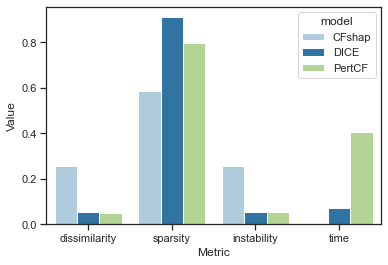

In [43]:
sns.set_style("ticks")
sns.set_context("notebook")

sns.barplot(data=df.melt('model'), x="variable", y='value', hue="model", palette = 'Paired')

plt.xlabel('Metric')
plt.ylabel('Value')

plt.savefig('./Output/img/comparison_result.png', dpi=1200, bbox_inches='tight')
#display barplot
plt.show()

In [44]:
df

,dissimilarity,sparsity,instability,time,model
0,0.255488,0.584211,0.255525,0.005750,CFshap
1,0.055744,0.911053,0.056013,0.073553,DICE
2,0.051702,0.798246,0.051817,0.406937,PertCF
